## Sentiment Classification

* [Import Libraries ](#section-1)
* [Read and Prep Data](#section-2)
* [Sentiment Classification with BERT](#section-4)
    - [Input Tokenization](#subsection-1)
    - [Training the Model](#subsection-2)
    - [Performance Metrics](#subsection-3)

<a id="section-1"></a>
## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import random as rn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import logging
transformers.logging.set_verbosity_error()
# logging.getLogger("tensorflow").setLevel(logging.WARNING)

<a id="section-2"></a>
## Read and Prep Data

#### The original dataset is quite large. I only read a subset of rows for faster run.

In [3]:
p = 0.002  # to randomly select n% of the rows

In [4]:
df_reviews = pd.read_csv('/kaggle/input/steam-reviews/dataset.csv', skiprows=lambda i: i>0 and rn.random() > p)
df_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,The Best Game :),1,0
1,10,Counter-Strike,700h and still playing it &lt;3,1,0
2,10,Counter-Strike,Nice game,1,0
3,10,Counter-Strike,I just love to play CS 1.6.. one of my favorit...,1,0
4,10,Counter-Strike,One of the best multiplayer-shooter ever! A re...,1,0


In [5]:
# size of dataframe
df_reviews.shape

(12900, 5)

In [6]:
# convert review text to string
df_reviews["review_text"] = df_reviews["review_text"].astype(str)

In [7]:
# drop the reviews with null score
df_reviews_2 = df_reviews[df_reviews["review_score"].notnull()]
df_reviews_2["review_score"] = np.where(df_reviews_2["review_score"]==-1, 0, df_reviews_2["review_score"])

In [8]:
# distribution of negative and positive reviews
df_reviews_2["review_score"].value_counts()

1    10572
0     2328
Name: review_score, dtype: int64

In [9]:
reviews = df_reviews_2["review_text"].values.tolist()
labels = df_reviews_2["review_score"].tolist()

In [10]:
# split the dataset into train, validation and holdout sets (60-20-20)
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

<a id="section-3"></a>
## Sentiment Classification with BERT

I use BERT to predict the sentiment of a review.

https://huggingface.co/docs/transformers/model_doc/bert

<a id="subsection-1"></a>
### Input Tokenization

In [11]:
# instantiate BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# example of the output of the tokenizer: 
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

{'input_ids': [[101, 1188, 1110, 157, 9919, 2240, 2559, 152, 26962, 1114, 3832, 1939, 1104, 24179, 117, 10221, 1116, 1939, 1104, 3974, 117, 1105, 16454, 1939, 1104, 21105, 1116, 119, 16068, 117, 2521, 1111, 1275, 109, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [13]:
# tokenize training, validation and hold-out sentences
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [14]:
# convert the input encodings and labels into a TensorFlow Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

<a id="subsection-2"></a>
### Training the Model

In [15]:
# initialize a pre-trained model
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=2)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

In [16]:
# create an optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [18]:
# train and fine-tune the model
history = model.fit(train_dataset.shuffle(100).batch(8),
          epochs=5,
          batch_size=8,
          validation_data=validation_dataset.shuffle(100).batch(8), verbose=1)

Epoch 1/5
968/968 [==============================] - 615s 635ms/step - loss: 0.3508 - accuracy: 0.8593 - val_loss: 0.2693 - val_accuracy: 0.9035
Epoch 2/5
968/968 [==============================] - 612s 632ms/step - loss: 0.2205 - accuracy: 0.9118 - val_loss: 0.3362 - val_accuracy: 0.8884
Epoch 3/5
968/968 [==============================] - 612s 632ms/step - loss: 0.1573 - accuracy: 0.9389 - val_loss: 0.3635 - val_accuracy: 0.8860
Epoch 4/5
968/968 [==============================] - 611s 631ms/step - loss: 0.1249 - accuracy: 0.9512 - val_loss: 0.4499 - val_accuracy: 0.8876
Epoch 5/5
968/968 [==============================] - 611s 631ms/step - loss: 0.1146 - accuracy: 0.9557 - val_loss: 0.4596 - val_accuracy: 0.8771


<a id="subsection-3"></a>
### Performance Metrics

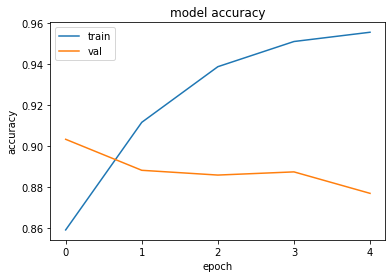

In [19]:
# plot train and validation accuracy
ax = plt.figure().gca()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# save the model
model.save_pretrained("./sent_model")

In [21]:
# load the model and evaluate the model on holdout set
loaded_model = TFBertForSequenceClassification.from_pretrained("./sent_model")
result = model.evaluate(holdout_dataset.batch(8))
dict(zip(model.metrics_names, result))

323/323 [==============================] - 64s 197ms/step - loss: 0.4813 - accuracy: 0.8698


{'loss': 0.48134973645210266, 'accuracy': 0.869767427444458}

In [22]:
# predict the sentiment for holdout set
tf_output = loaded_model.predict(holdout_dataset.batch(8))
pred_label = tf.argmax(tf.nn.softmax(tf_output["logits"], axis=1).numpy(), 1).numpy()

In [23]:
# generate the confusion matrix
cm = tf.math.confusion_matrix(
    holdout_labels, pred_label, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None
).numpy()

print("confusion matrix\n",cm)

confusion matrix
 [[ 284  172]
 [ 164 1960]]


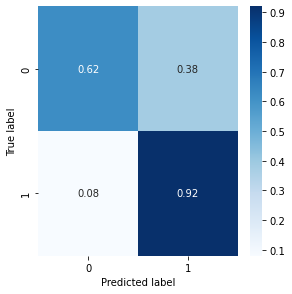

In [24]:
# visualize the confusion matrix
cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

cm_df = pd.DataFrame(cm_norm,
                 index = [0,1], 
                 columns =[0,1])

figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
# calculate recall and precision

tp = cm[0][0]
fn = cm[0][1]

tn = cm[1][1]
fp = cm[1][0]

recall = round(tp / (tp+fn), 2)
precision = round(tp / (tp+fp), 2)

print("recall score:", recall)
print("precision score:", precision)

recall score: 0.62
precision score: 0.63


In [26]:
# altenatively you can use sklearn.classification_report:
print(classification_report(holdout_labels, pred_label))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       456
           1       0.92      0.92      0.92      2124

    accuracy                           0.87      2580
   macro avg       0.78      0.77      0.77      2580
weighted avg       0.87      0.87      0.87      2580



In [28]:
# example of a prediction
index = 91
print("example sentence:\n", holdout_sentences[index])
print("\nsentiment:", holdout_labels[index])
print("prediction:", pred_label[index])

example sentence:
 Would have been a 10 if it had cross platform party support.  Due to it not having this i can only give it an 8.

sentiment: 1
prediction: 1


You can see that the current model is not very good at predicting the negative sentiments and needs additional fine-tuning and/or more training data.